## 获取/判断股票涨跌停

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
pd.set_option('display.max_rows', 50)

/mnt/datadisk2/aglv/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
open2021 = pd.read_hdf('/mnt/datadisk2/aglv/aglv/lab_aglv/open_2021.h5')
open2021 = open2021.set_index(['Date', 'EndTime'])
open2021

InstrumentID      SH600000  SH600004  SH600006  SH600007  SH600008  SH600009  \
Date     EndTime                                                               
20210104 09:31        9.64     14.10      8.95     12.45      2.86     75.70   
         09:32        9.64     14.01      8.82     12.35      2.86     76.46   
         09:33        9.60     13.97      8.84     12.36      2.84     76.17   
         09:34        9.60     14.00      8.83     12.37      2.85     76.10   
         09:35        9.58     13.90      8.83     12.33      2.85     75.74   
...                    ...       ...       ...       ...       ...       ...   
20211231 14:56        8.55     12.04      6.81     14.41      3.41     46.68   
         14:57        8.54     12.03      6.81     14.41      3.40     46.68   
         14:58        8.55     12.03      6.81     14.39      3.41     46.70   
         14:59        8.55     12.03      6.81     14.39      3.41     46.70   
         15:00        8.55     12.03      6.81     14.39      3.41     46.70   

InstrumentID      SH600010  SH600011  SH600012  SH600015  ...  SZ301190  \
Date     EndTime                                          ...             
20210104 09:31        1.17      4.50      6.14      6.22  ...       NaN   
         09:32        1.18      4.49      6.12      6.22  ...       NaN   
         09:33        1.17      4.47      6.16      6.20  ...       NaN   
         09:34        1.17      4.47      6.17      6.21  ...       NaN   
         09:35        1.17      4.46      6.16      6.21  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
20211231 14:56        2.78      9.64      7.07      5.59  ...     30.31   
         14:57        2.79      9.65      7.07      5.59  ...     30.28   
         14:58        2.79      9.65      7.06      5.60  ...     30.20   
         14:59        2.79      9.65      7.06      5.60  ...     30.20   
         15:00        2.79      9.65      7.06      5.60  ...     30.20   

InstrumentID      SH688210  SH688206  SH688265  SZ301166  SZ301189  SH688227  \
Date     EndTime                                                               
20210104 09:31         NaN       NaN       NaN       NaN       NaN       NaN   
         09:32         NaN       NaN       NaN       NaN       NaN       NaN   
         09:33         NaN       NaN       NaN       NaN       NaN       NaN   
         09:34         NaN       NaN       NaN       NaN       NaN       NaN   
         09:35         NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
20211231 14:56       41.48     36.95     69.92    104.04     60.49     32.14   
         14:57       41.51     36.93     70.00    103.70     60.32     32.12   
         14:58       41.48     36.73     70.05    103.20     60.05     32.09   
         14:59       41.48     36.73     70.05    103.30     60.02     32.09   
         15:00       41.48     36.73     70.05    103.30     60.02     32.09   

InstrumentID      SH688236  SZ301127  SH603176  
Date     EndTime                                
20210104 09:31         NaN       NaN       NaN  
         09:32         NaN       NaN       NaN  
         09:33         NaN       NaN       NaN  
         09:34         NaN       NaN       NaN  
         09:35         NaN       NaN       NaN  
...                    ...       ...       ...  
20211231 14:56       27.39     20.23      2.45  
         14:57       27.40     20.30      2.45  
         14:58       27.39     20.25      2.45  
         14:59       27.39     20.19      2.45  
         15:00       27.39     20.19      2.45  

[58320 rows x 4622 columns]

In [11]:
def is_stop_trade(price:pd.DataFrame, std_level=1e-6, back_period=-100, updown_level=0.08):
    '''
    判断某只股票是否涨停跌停, 1为可以正常交易, 0为涨停跌停 
    price:分钟级价格数据, multi-index对象 
    std_level:认为停止交易的数据标准差阈值 
    back_period:回溯时间期, 单位min
    updown_level:认为涨跌停幅度阈值
    '''

    def _is_stop_trade(price_daily:pd.DataFrame):
        return pd.Series(np.where(
            (price_daily.iloc[back_period:].std() < std_level) & (np.abs(price_daily.iloc[-1] / price_daily.iloc[0]) - 1 > updown_level),
            0, 1), index=price_daily.columns)
    
    return pd.DataFrame(price.groupby(level='Date').progress_apply(_is_stop_trade), columns=price.columns)

def get_stop_stock(price:pd.DataFrame, std_level=1e-6, back_period=-15, updown_level=0.08):
    '''
    返回在某个日期涨停跌停的股票
    price:分钟级价格数据, multi-index对象 
    std_level:认为停止交易的数据标准差阈值 
    back_period:回溯时间期, 单位min
    updown_level:认为涨跌停幅度阈值
    '''
    
    def _get_stop_stock(price_daily:pd.DataFrame):
        jg = (price_daily.iloc[back_period:].std() < std_level) & (np.abs(price_daily.iloc[-1] / price_daily.iloc[0]) - 1 > updown_level)
        return jg[jg == True].index.to_list()
    
    return price.groupby(level='Date').progress_apply(_get_stop_stock)

In [3]:
def is_stop_trade(price:pd.DataFrame, std_level=1e-6, back_period=-15, updown_level=0.1):
    '''
    判断某只股票是否涨停跌停, 1为可以正常交易, 0为涨停跌停 
    price:分钟级价格数据, multi-index对象 
    std_level:认为停止交易的数据标准差阈值 
    back_period:回溯时间期, 单位min
    updown_level:认为涨跌停幅度阈值
    '''

    def _is_stop_trade(price_daily:pd.DataFrame):
        return pd.Series(np.where(
            (price_daily.max() / price_daily.iloc[0] - 1 > updown_level) | (1 - price_daily.min() / price_daily.iloc[0] > updown_level),
            0, 1), index=price_daily.columns)
    
    return pd.DataFrame(price.groupby(level='Date').progress_apply(_is_stop_trade), columns=price.columns)

In [12]:
stop_stock = is_stop_trade(open2021)
stop_stock

InstrumentID,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301190,SH688210,SH688206,SH688265,SZ301166,SZ301189,SH688227,SH688236,SZ301127,SH603176
Date,,,,,,,,,,,,,,,,,,,,,
20210104,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20210105,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20210106,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20210107,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20210108,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20211228,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20211229,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [13]:
stop_stock = stop_stock.replace(0, np.nan)
stop_stock

InstrumentID,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301190,SH688210,SH688206,SH688265,SZ301166,SZ301189,SH688227,SH688236,SZ301127,SH603176
Date,,,,,,,,,,,,,,,,,,,,,
20210104,1,1,1.0,1.0,1.0,1,1.0,1.0,1,1,...,1,1,1,1,1,1,1,1,1,1.0
20210105,1,1,1.0,1.0,1.0,1,1.0,1.0,1,1,...,1,1,1,1,1,1,1,1,1,1.0
20210106,1,1,1.0,1.0,1.0,1,1.0,1.0,1,1,...,1,1,1,1,1,1,1,1,1,1.0
20210107,1,1,1.0,1.0,1.0,1,1.0,1.0,1,1,...,1,1,1,1,1,1,1,1,1,1.0
20210108,1,1,1.0,1.0,1.0,1,1.0,1.0,1,1,...,1,1,1,1,1,1,1,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,1,1,1.0,1.0,1.0,1,1.0,1.0,1,1,...,1,1,1,1,1,1,1,1,1,1.0
20211228,1,1,1.0,1.0,1.0,1,1.0,1.0,1,1,...,1,1,1,1,1,1,1,1,1,1.0
20211229,1,1,1.0,1.0,1.0,1,1.0,1.0,1,1,...,1,1,1,1,1,1,1,1,1,1.0


In [14]:
stop_stock.isna().sum(axis=1)

Date
20210104    27
20210105    25
20210106    17
20210107     6
20210108    20
            ..
20211227    30
20211228    31
20211229    30
20211230    44
20211231    19
Length: 243, dtype: int64

In [15]:
s_s_0104 = stop_stock.isna().iloc[0][stop_stock.isna().iloc[0]].index.tolist()
s_s_0104

['SH600059',
 'SH600184',
 'SH600219',
 'SH600456',
 'SH600569',
 'SH600732',
 'SH600740',
 'SH600971',
 'SH600975',
 'SH601222',
 'SH603126',
 'SH603728',
 'SH688568',
 'SZ000150',
 'SZ000791',
 'SZ001896',
 'SZ002006',
 'SZ002507',
 'SZ002518',
 'SZ002548',
 'SZ002597',
 'SZ002631',
 'SZ002837',
 'SZ002848',
 'SZ002982',
 'SZ003031',
 'SZ300762']

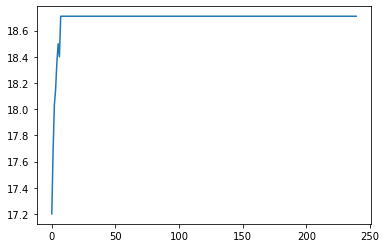

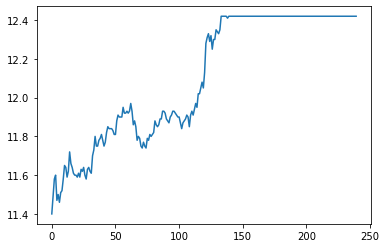

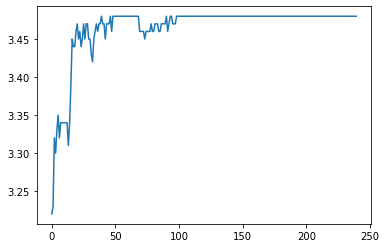

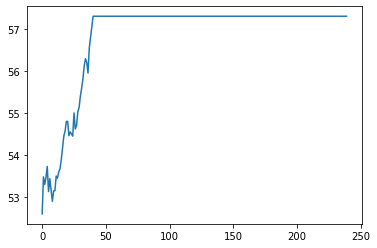

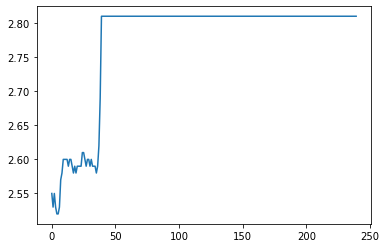

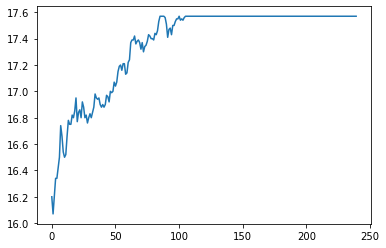

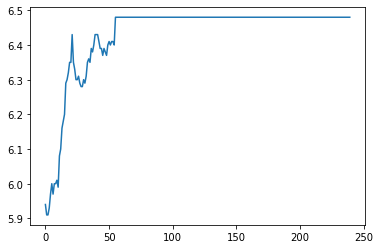

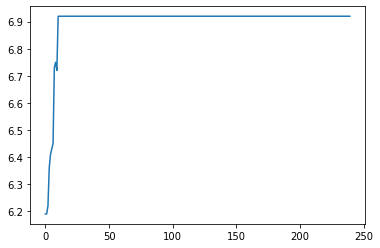

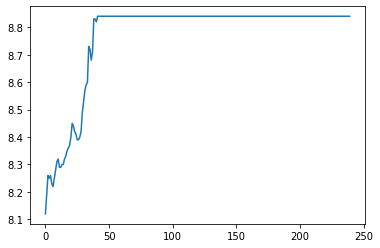

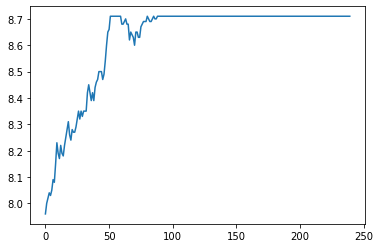

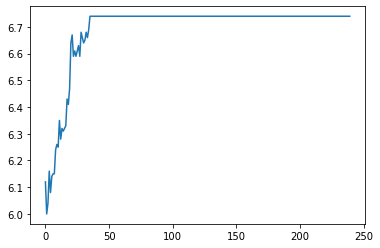

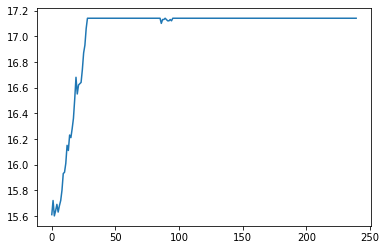

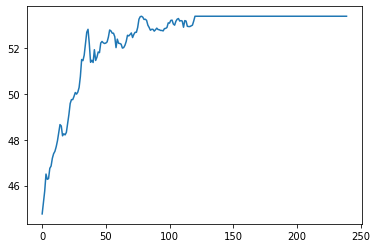

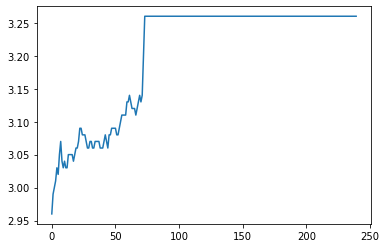

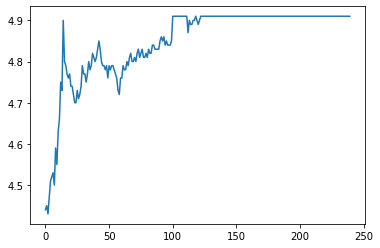

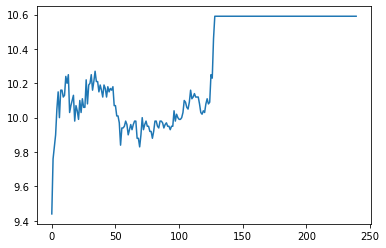

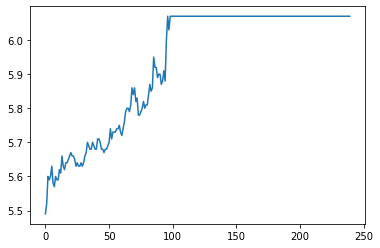

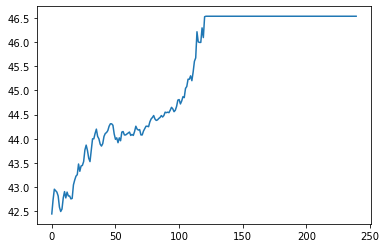

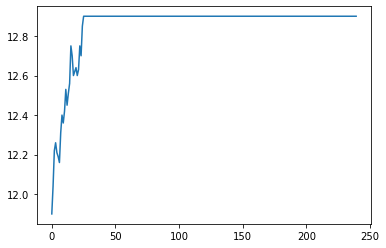

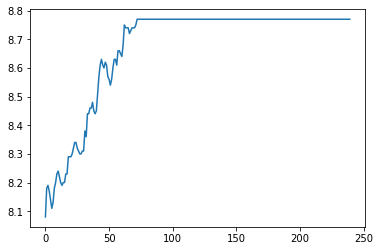

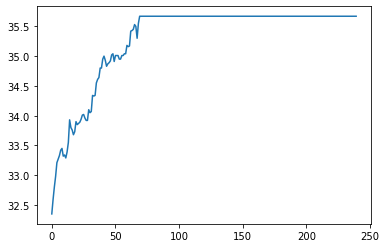

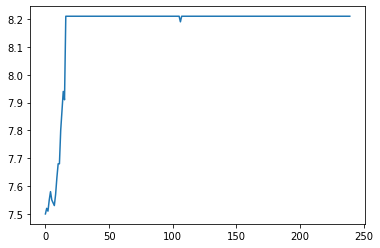

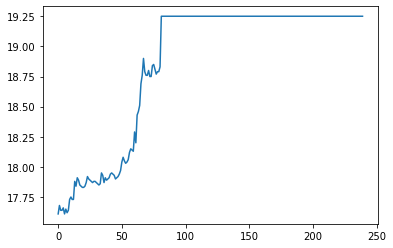

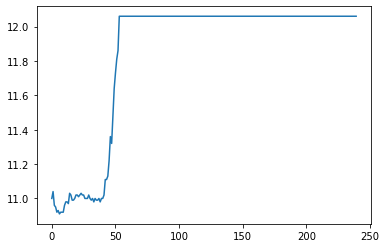

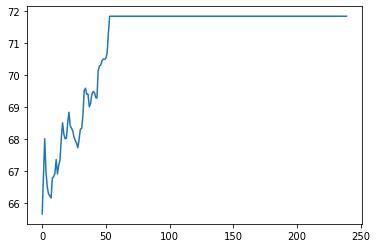

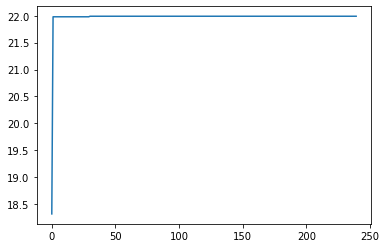

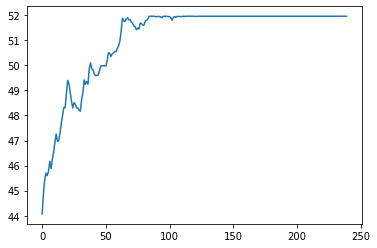

In [16]:
import matplotlib.pyplot as plt
for i in range(len(s_s_0104)):
    s = open2021[s_s_0104[i]]
    plt.plot(s[:240].values)
    plt.show()

In [17]:
factor = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/fa_21_23/longshort_v3_vol_ret_w15_21_min.csv')
factor = factor.set_index('Date')
factor

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301186,SZ301188,SZ301189,SZ301190,SZ301193,SZ301198,SZ301199,SZ301211,SZ301213,SZ301221
Date,,,,,,,,,,,,,,,,,,,,,
20210104,0.000284,0.000372,0.000957,0.000211,0.000252,0.000649,0.000691,0.000306,0.000211,0.000324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,0.000240,0.000236,0.001196,0.000136,0.000306,0.000140,0.000691,0.000256,0.000484,0.000464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,0.000199,0.000199,0.000508,0.000544,0.000160,0.000497,0.000547,0.000366,0.000731,0.000397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,0.000339,0.000205,0.001019,0.004656,0.000408,0.000173,0.003068,0.000570,0.000371,0.000152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,0.000219,0.000457,0.000653,0.000341,0.001480,0.000370,0.000326,0.000329,0.000598,0.000231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.000066,0.000306,0.000155,0.000441,0.000233,0.000317,0.000901,0.000979,0.000363,0.000114,...,0.001210,0.000284,NaN,0.003112,0.000288,0.001027,0.000709,0.001675,0.000780,0.002857
20211228,0.000104,0.000448,0.000135,0.000297,0.000448,0.000251,0.000391,0.000524,0.000968,0.000135,...,0.001482,0.000245,0.002004,0.000497,0.000421,0.000364,0.003071,0.001456,0.000458,0.000686
20211229,0.000076,0.000366,0.000116,0.000220,0.001028,0.000267,0.000519,0.000574,0.000595,0.000188,...,0.002287,0.000520,0.000920,0.001273,0.000339,0.000368,0.000462,0.001765,0.000471,0.000762


In [18]:
factor.index = stop_stock.index
factor.index

Index(['20210104', '20210105', '20210106', '20210107', '20210108', '20210111',
       '20210112', '20210113', '20210114', '20210115',
       ...
       '20211220', '20211221', '20211222', '20211223', '20211224', '20211227',
       '20211228', '20211229', '20211230', '20211231'],
      dtype='object', name='Date', length=243)

In [19]:
new_factor = factor * stop_stock
new_factor

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301186,SZ301188,SZ301189,SZ301190,SZ301193,SZ301198,SZ301199,SZ301211,SZ301213,SZ301221
Date,,,,,,,,,,,,,,,,,,,,,
20210104,0.000284,0.000372,0.000957,0.000211,0.000252,0.000649,0.000691,0.000306,0.000211,0.000324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,0.000240,0.000236,0.001196,0.000136,0.000306,0.000140,0.000691,0.000256,0.000484,0.000464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,0.000199,0.000199,0.000508,0.000544,0.000160,0.000497,0.000547,0.000366,0.000731,0.000397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,0.000339,0.000205,0.001019,0.004656,0.000408,0.000173,0.003068,0.000570,0.000371,0.000152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,0.000219,0.000457,0.000653,0.000341,0.001480,0.000370,0.000326,0.000329,0.000598,0.000231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.000066,0.000306,0.000155,0.000441,0.000233,0.000317,0.000901,0.000979,0.000363,0.000114,...,0.001210,0.000284,NaN,0.003112,0.000288,0.001027,0.000709,0.001675,0.000780,0.002857
20211228,0.000104,0.000448,0.000135,0.000297,0.000448,0.000251,0.000391,0.000524,0.000968,0.000135,...,0.001482,0.000245,0.002004,0.000497,0.000421,0.000364,0.003071,0.001456,0.000458,0.000686
20211229,0.000076,0.000366,0.000116,0.000220,0.001028,0.000267,0.000519,0.000574,0.000595,0.000188,...,0.002287,0.000520,0.000920,0.001273,0.000339,0.000368,0.000462,0.001765,0.000471,0.000762


In [20]:
new_factor.isna().sum(axis=1)

Date
20210104    526
20210105    523
20210106    513
20210107    497
20210108    510
           ... 
20211227     66
20211228     64
20211229     62
20211230     74
20211231     50
Length: 243, dtype: int64

In [21]:
new_factor.to_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/fa_21_23/longshort_v3_vol_ret_w15_21_dropstop_min.csv')

In [22]:
new_factor_r5mean = new_factor.rolling(5).mean()
new_factor_r5mean.to_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/fa_21_23/longshort_v3_vol_ret_w15_21_dropstop_min.csv')
